In [39]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm, trange
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = "../datasets/Fer2013_filtered/"
model_dir = "models/Fer2013_Aug_Disgust_uniform_e_03_identity/"

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [4]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
batch_size = 64

In [6]:
class ImageClassificationBase(nn.Module):
    
    def __init__(self, loss_function, metrics):
        super().__init__()
        self.loss_function = loss_function
        self.metrics = metrics
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.loss_function(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.loss_function(out, labels)   # Calculate loss
        result = {'val_loss': loss.detach()}
        
        for m in self.metrics:
            result[m.name] = m.eval(out, labels)           # Calculate metrics
            
        return result
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        
        result = {'val_loss': epoch_loss.item()}
        
        for m in self.metrics:
            batch = [x[m.name] for x in outputs]
            epoch = torch.stack(batch).mean()      # Combine metrics
            result[m.name] = epoch.item()
            
        return result
    
    def epoch_end(self, epoch, result):
        out = f"Epoch [{epoch}]"
        vals = list(result.keys())
        for v in vals:
            out += f", {v}: {result[v]:.3e}"
        print(out)

In [7]:
class Net(ImageClassificationBase):
    
    def __init__(self, loss_function, metrics, out_size):
        super().__init__(loss_function, metrics)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(in_features=128*5*5, out_features=256)
        #self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc = nn.Linear(256, out_size)

    def forward(self, input):
        output = self.norm1(self.pool1(F.relu(self.conv1(input))))
        output = self.norm2(self.pool2(F.relu(self.conv2((output)))))
        output = self.norm3(self.pool3(F.relu(self.conv3((output)))))
        output = output.view(-1, 128*5*5)
        output = F.relu(self.fc1(output))
        #output = F.relu(self.fc2(output))
        output = self.fc(output)
        output = F.softmax(input = output, dim=-1)
        return output

In [8]:
df_test = ImageFolder(root=dataset, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))

In [9]:
classes = df_test.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
counts = dict(Counter(df_test.targets))
print(counts)
weights = np.array(list(counts.values()))
weights = torch.Tensor( min(weights)/weights)
print(weights)

{0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6198, 5: 6077, 6: 4002}
tensor([0.1104, 1.0000, 0.1068, 0.0609, 0.0883, 0.0900, 0.1367])


In [11]:
test_dl = DeviceDataLoader(DataLoader(df_test, batch_size=batch_size, shuffle=False),device)

In [12]:
models = []

for fold, model in enumerate(os.listdir(model_dir)):
    net = Net(nn.CrossEntropyLoss(weights), [], 7)
    net.load_state_dict(torch.load(os.path.join(model_dir,model)))
    net.eval()
    net.cuda()
    models.append( net )

In [13]:
def get_model_predicitons(model, dataset):
    y_test = []
    y_scores = []

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(dataset):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            y_test.extend(labels.tolist())
            y_scores.extend(outputs.tolist())

    y_test = np.array(y_test)
    y_scores = np.array(y_scores)

    return y_test, y_scores

In [14]:
y_tests = []
y_scoress = []
for model in models:
    y_test, y_scores = get_model_predicitons(model,test_dl)
    y_tests.append(y_test)
    y_scoress.append(y_scores)

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/561 [00:00<?, ?it/s]

In [15]:
y_tests[1].shape

(35887,)

In [16]:
distr = dict()
for i,c in enumerate(classes):
    distr[i] = []

In [17]:
y_tests[0].shape[0]

35887

In [18]:
img_correctness =[]
for i in range(y_tests[0].shape[0]):
    res = [y_scoress[fold][i,y_tests[fold][i]] for fold in range(len(y_tests))]
    img_correctness.append(np.mean(res))
    distr[y_tests[fold][i]].append(np.mean(res))

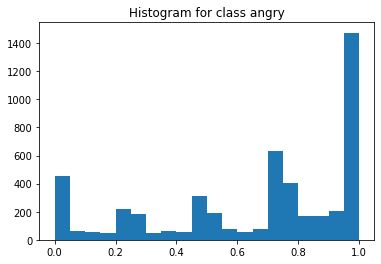

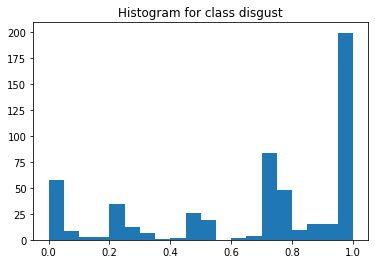

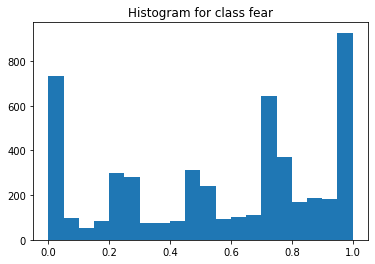

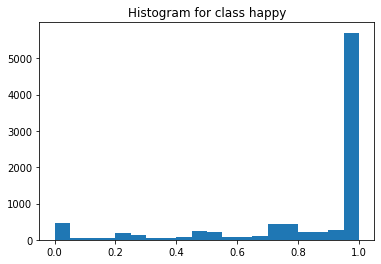

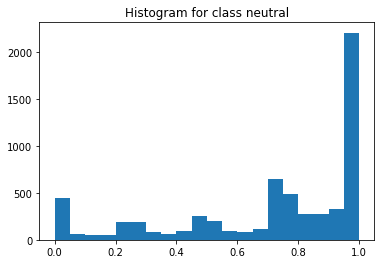

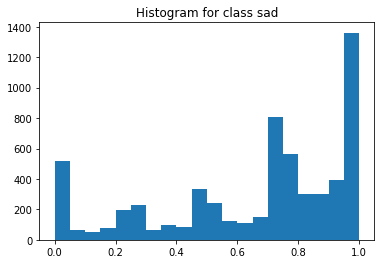

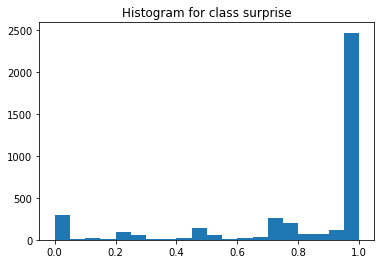

In [19]:
for i,c in enumerate(classes):
    plt.hist(distr[i], bins=20)
    plt.title(f"Histogram for class {c}")
    plt.show()

In [26]:
len(img_correctness)

35887

In [47]:
dataset_new = "../datasets/Fer2013_filtered"
os.makedirs(dataset_new, exist_ok=True)
for c in classes:
    os.makedirs(os.path.join(dataset_new,c), exist_ok=True)

In [48]:
for img, prob in enumerate(img_correctness):

    if prob>0.4:
        class_path = os.path.join(dataset_new,classes[y_tests[0][img]])
        img_name = test_dl.dl.dataset.imgs[img][0]
        shutil.copy(img_name, os.path.join(class_path, img_name.split("\\")[-1] ))
        